<a href="https://colab.research.google.com/github/Nicola-Ibrahim/Pareto-Optimization/blob/main/notebooks/01_pareto_front.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electric Vehicle Control Optimization

## System Definition
We model an electric vehicle (EV) traveling a fixed distance $D$, where we control its acceleration profile to optimize:
1. **Travel Time ($T$)** - Minimize total trip duration
2. **Energy Consumption ($E$)** - Minimize total energy used

## State-Space Representation
| Variable | Symbol | Units   | Description                          |
|----------|--------|---------|--------------------------------------|
| $ x(t) $ | Position | m      | Distance traveled                    |
| $ v(t) $ | Velocity | m/s    | Instantaneous speed                  |
| $ E(t) $ | Energy   | kWh    | Cumulative energy consumption       |

### Control Parameterization
| Phase | Control Input | Symbol | Bounds (m/s²) | Description              |
|-------|---------------|--------|---------------|--------------------------|
| 1     | Acceleration  | $ u_1 $ | [0.3, 4.0]    | Constant acceleration    |
| 2     | Deceleration  | $ u_2 $ | [0.3, 4.0]    | Constant deceleration    |



## System Dynamics
The EV's motion is governed by:

\begin{cases}
\dot{x}(t) = v(t) & \text{(Position)} \\
\dot{v}(t) = \frac{u(t)}{m} - \frac{F_{drag}(v) + F_{roll}}{m} & \text{(Velocity)} \\
F_{drag} = \frac{1}{2}\rho C_d A v^2(t) & \text{(Drag force)} \\
F_{roll} = C_r m g & \text{(Rolling resistance)}
\end{cases}

### Initial Conditions
\begin{aligned}
x(0) = 0,\ v(0) = 0
\end{aligned}

### Terminal Condition
\begin{aligned}
x(T) = D \quad \text{(Must reach target distance)}
\end{aligned}

## Optimization Problem Formulation

### Objectives
\begin{aligned}
\min_{u(t)} \mathbf{J} = \begin{bmatrix} T \\ E \end{bmatrix}
\end{aligned}

1. **Travel Time ($T$)**:
\begin{aligned}
   T = \inf \left\{ t \, \big| \, x(t) = D \right\}
   \end{aligned}
   - $D$: Total travel distance  
   - $x(t)$: Position at time $t$

2. **Energy Consumption ($E$)**:
\begin{aligned}
   E(u) = \int_0^T P\big(u(t), v(t)\big) \, dt
   \end{aligned}
   \begin{aligned}
   P(u,v) = \frac{u(t) \cdot v(t)}{\eta} + P_{\text{aux}}
   \end{aligned}
   - $\eta$: Motor efficiency (0 < $\eta$ ≤ 1)  
   - $P_{\text{aux}}$: Constant auxiliary power  
   - $u(t)$: Control input (acceleration/deceleration)  
   - $v(t)$: Velocity

### Hard Constraints
1. **Control Inputs**:
   $
   u_1 \in [0.3, 4.0]\, \text{m/s}^2,\quad u_2 \in [0.3, 4.0]\, \text{m/s}^2
   $
   
2. **Speed Limit**:
   $
   v(t) \leq v_{max} = 30\, \text{m/s}\quad \forall t\in[0,T]
   $

3. **Battery Limit**:
   $
   E_{total} \leq 20\%, E_{batt} = 0.4\, \text{kWh}
   $

4. **Distance Completion**:
   $
   x(T) = D = 1000\, \text{m} \pm 0.1\%
   $


## Physical Parameters

| Parameter | Symbol | Value | Units | Description |
|-----------|--------|-------|-------|-------------|
| Vehicle mass | \( m \) | 1000 | kg | Total curb weight |
| Drag coefficient | \( C_d \) | 0.24 | - | Aerodynamic profile |
| Frontal area | \( A \) | 2.4 | m² | Cross-sectional area |
| Rolling resistance | \( C_r \) | 0.008 | - | Tire-road friction |
| Motor efficiency | \( \eta_{mtr} \) | 0.85 | - | Drivetrain efficiency |
| Regen efficiency | \( \eta_{regen} \) | 0.70 | - | Braking recovery |
| Air density | \( \rho \) | 1.225 | kg/m³ | Sea level conditions |
| Auxiliary power | \( P_{aux} \) | 300 | W | Electronics load |

## Implementation Notes
- **Discretization**: The continuous control $u(t)$ is parameterized as:
  - $u_1$: Constant acceleration in Phase 1
  - $u_2$: Constant deceleration in Phase 2
- **Numerical Integration**: Trapezoidal rule used for energy calculation
- **Constraints Handling**: Normalized constraints ensure balanced optimization



In [16]:
import numpy as np
from typing import Any
from pathlib import Path
import pickle
import pandas as pd

# Import optimizer modules
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.population import Population
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.core.result import Result

# Import plotting modules
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


### EVControl Problem

In [17]:
class EVControlProblem(Problem):
    """
    Multi-objective optimization problem for electric vehicle motion control.
    Optimizes acceleration/deceleration strategies to balance travel time and energy consumption.

    Objectives:
    1. Minimize total travel time (minutes)
    2. Minimize energy consumption (kWh)

    Constraints:
    1. Vehicle speed must not exceed allowed maximum
    2. Total energy used must not exceed battery capacity
    3. Control inputs must stay within acceleration/deceleration limits
    """

    def __init__(self) -> None:
        """Initialize vehicle parameters and problem configuration"""

        # ========================
        # Vehicle Physical Parameters
        # ========================
        self.vehicle_mass_kg = 1000            # Total mass of the vehicle
        self.air_density_kg_per_m3 = 1.225     # Air density at standard conditions
        self.drag_coefficient = 0.24           # Aerodynamic shape efficiency
        self.frontal_area_m2 = 2.4             # Cross-sectional area facing airflow
        self.rolling_resistance_coeff = 0.008  # Tire-road friction coefficient
        self.motor_efficiency = 0.85           # Power conversion efficiency (motor)
        self.regenerative_efficiency = 0.70    # Energy recovery efficiency (braking)
        self.auxiliary_power_watt = 300        # Constant power for non-drive systems

        # ========================
        # Operational Constraints
        # ========================
        self.max_speed_mps = 20                # 72 km/h (20 m/s) speed limit
        self.battery_capacity_kwh = 10.0       # Total battery capacity
        self.initial_state_of_charge = 0.9     # Starting charge level (90%)
        self.minimum_state_of_charge = 0.2     # Safety threshold for battery drain

        # Energy availability calculation
        self.available_energy_kwh = (self.initial_state_of_charge -
                                   self.minimum_state_of_charge) * self.battery_capacity_kwh

        # ========================
        # Mission Parameters
        # ========================
        self.target_distance_km = 5.0          # Trip distance requirement
        self.target_distance_m = self.target_distance_km * 1000  # Convert to meters

        # ========================
        # Control Input Limits
        # ========================
        self.min_acceleration = 0.2   # m/s² (comfort-focused minimum)
        self.max_acceleration = 2.0   # m/s² (performance-focused maximum)

        # Initialize optimization problem structure
        super().__init__(
            n_var=2,        # Decision variables: [acceleration_rate, deceleration_rate]
            n_obj=2,        # Objectives: [time_minutes, energy_kwh]
            n_constr=3,      # Constraints: [speed_limit, energy_limit, control_bounds]
            xl=np.array([self.min_acceleration, self.min_acceleration]),
            xu=np.array([self.max_acceleration, self.max_acceleration])
        )

    def _clamp_velocity(self, velocity: float) -> float:
        """Ensure velocity stays within physical and regulatory limits"""
        return np.clip(velocity, 0, self.max_speed_mps)

    def _calculate_resistive_forces(self, velocity: float) -> tuple[float, float]:
        """
        Compute opposing forces affecting vehicle motion

        Args:
            velocity: Current vehicle speed in m/s

        Returns:
            tuple: (aerodynamic_drag_force [N], rolling_resistance_force [N])
        """
        aerodynamic_drag = 0.5 * self.air_density_kg_per_m3 * self.drag_coefficient * \
                         self.frontal_area_m2 * velocity**2
        rolling_resistance = self.rolling_resistance_coeff * self.vehicle_mass_kg * 9.81

        return aerodynamic_drag, rolling_resistance

    def _simulate_vehicle_motion(self, acceleration_rate: float,
                                deceleration_rate: float) -> tuple[float, float, float]:
        """
        Simulate vehicle trip through acceleration, cruising, and deceleration phases

        Args:
            acceleration_rate: Control input for acceleration (m/s²)
            deceleration_rate: Control input for braking (m/s²)

        Returns:
            tuple: (total_time_minutes, peak_velocity_mps, actual_distance_m)
        """
        SIMULATION_TIMESTEP = 0.1  # Seconds between state updates

        time_elapsed = 0.0
        distance_traveled = 0.0
        current_velocity = 0.0
        peak_velocity = 0.0

        # Phase 1: Acceleration to cruising speed
        while (current_velocity < self.max_speed_mps and
               distance_traveled < self.target_distance_m):
            current_velocity = self._clamp_velocity(
                current_velocity + acceleration_rate * SIMULATION_TIMESTEP
            )
            distance_traveled += current_velocity * SIMULATION_TIMESTEP
            time_elapsed += SIMULATION_TIMESTEP
            peak_velocity = max(peak_velocity, current_velocity)

        # Phase 2: Constant speed cruising (if distance remains)
        remaining_distance = self.target_distance_m - distance_traveled
        if remaining_distance > 0:
            cruise_duration = remaining_distance / self.max_speed_mps
            time_elapsed += cruise_duration
            distance_traveled = self.target_distance_m  # Fully covered

        # Phase 3: Controlled deceleration to stop
        while distance_traveled < self.target_distance_m and current_velocity > 0:
            current_velocity = self._clamp_velocity(
                current_velocity - deceleration_rate * SIMULATION_TIMESTEP
            )
            distance_traveled += current_velocity * SIMULATION_TIMESTEP
            time_elapsed += SIMULATION_TIMESTEP

        return time_elapsed / 60, peak_velocity, distance_traveled

    def _calculate_energy_consumption(self, acceleration_rate: float,
                                    deceleration_rate: float) -> float:
        """
        Calculate total energy expenditure during the trip

        Args:
            acceleration_rate: Control input for acceleration (m/s²)
            deceleration_rate: Control input for braking (m/s²)

        Returns:
            float: Total energy consumed in kWh
        """
        SIMULATION_TIMESTEP = 0.1  # Seconds between energy calculations
        energy_watt_hours = 0.0
        current_velocity = 0.0
        distance_traveled = 0.0

        while distance_traveled < self.target_distance_m:
            # Determine current operational phase
            if current_velocity < self.max_speed_mps:
                operation_phase = "accelerating"
                current_acceleration = acceleration_rate
            else:
                braking_distance = current_velocity**2 / (2 * deceleration_rate)
                remaining_distance = self.target_distance_m - distance_traveled
                operation_phase = "braking" if remaining_distance <= braking_distance else "cruising"
                current_acceleration = -deceleration_rate if operation_phase == "braking" else 0

            # Calculate power requirements for current state
            drag_force, rolling_force = self._calculate_resistive_forces(current_velocity)

            if operation_phase == "accelerating":
                mechanical_power = (self.vehicle_mass_kg * current_acceleration +
                                  drag_force + rolling_force) * current_velocity
                effective_power = mechanical_power / self.motor_efficiency
            elif operation_phase == "braking":
                mechanical_power = (self.vehicle_mass_kg * current_acceleration +
                                  drag_force + rolling_force) * current_velocity
                effective_power = mechanical_power * self.regenerative_efficiency
            else:  # Cruising
                mechanical_power = (drag_force + rolling_force) * current_velocity
                effective_power = mechanical_power / self.motor_efficiency

            # Sum total energy consumption with auxiliary systems
            total_power = effective_power + self.auxiliary_power_watt
            energy_watt_hours += total_power * SIMULATION_TIMESTEP / 3600  # Convert to Wh

            # Update kinematic state
            current_velocity = self._clamp_velocity(
                current_velocity + current_acceleration * SIMULATION_TIMESTEP
            )
            distance_traveled += current_velocity * SIMULATION_TIMESTEP

        return energy_watt_hours / 1000  # Convert to kWh

    def _evaluate(self, population: np.ndarray, out: dict[str, Any],
                *args, **kwargs) -> None:
        """
        Evaluate a population of candidate solutions

        Args:
            population: Array of candidate solutions (acceleration/deceleration pairs)
            out: Dictionary for storing objectives and constraints
        """
        objective_values = []
        constraint_violations = []

        for accel_rate, decel_rate in population:
            # Simulate vehicle motion with current control parameters
            trip_time, max_speed, final_distance = self._simulate_vehicle_motion(
                accel_rate, decel_rate
            )

            # Calculate energy expenditure
            energy_used = self._calculate_energy_consumption(accel_rate, decel_rate)

            # Calculate constraint violations (normalized)
            speed_violation = max(0, (max_speed - self.max_speed_mps) / self.max_speed_mps)
            energy_violation = max(0, (energy_used - self.available_energy_kwh) /
                                 self.available_energy_kwh)

            # Control input constraint checks
            accel_violation = max(
                (self.min_acceleration - accel_rate)/self.min_acceleration
                if accel_rate < self.min_acceleration else 0,
                (accel_rate - self.max_acceleration)/self.max_acceleration
                if accel_rate > self.max_acceleration else 0
            )
            decel_violation = max(
                (self.min_acceleration - decel_rate)/self.min_acceleration
                if decel_rate < self.min_acceleration else 0,
                (decel_rate - self.max_acceleration)/self.max_acceleration
                if decel_rate > self.max_acceleration else 0
            )
            control_violation = max(accel_violation, decel_violation)

            # Store evaluation results
            objective_values.append([trip_time, energy_used])
            constraint_violations.append([
                speed_violation,
                energy_violation,
                control_violation
            ])

        # Format outputs for optimization framework
        out["F"] = np.array(objective_values)
        out["G"] = np.array(constraint_violations)

#### Simplified implementation

In [18]:
# class EVControlProblem(Problem):
#     """Simplified EV Control Problem with analytical solutions.

#     Key Assumptions:
#     1. Fixed acceleration/deceleration phases
#     2. Simplified energy calculation using average velocity
#     3. Closed-form time and distance equations
#     """

#     def __init__(self):
#         # Vehicle parameters (SI units)
#         self.m = 1000           # Mass [kg]
#         self.ρ = 1.225          # Air density
#         self.CdA = 0.24 * 2.4   # Combined drag coefficient & area
#         self.Cr = 0.008         # Rolling resistance
#         self.η = 0.85           # Efficiency
#         self.D = 1000           # Total distance [m]
#         self.v_max = 30         # Speed limit [m/s]

#         # Bounds for acceleration commands [m/s²]
#         super().__init__(n_var=2, n_obj=2, n_constr=1,
#                          xl=[0.3, 0.3], xu=[4.0, 4.0])

#     def _calculate_time_energy(self, a1: float, a2: float) -> tuple:
#         """Analytical solution for time and energy"""
#         # Phase 1: Acceleration to v_max or natural limit
#         t1 = min(np.sqrt(2*(self.D/2)/a1), self.v_max/a1)
#         d1 = 0.5 * a1 * t1**2
#         v1 = a1 * t1

#         # Phase 2: Deceleration from v1 to 0
#         t2 = v1 / a2
#         d2 = v1 * t2 - 0.5 * a2 * t2**2

#         # Handle remaining distance if needed
#         if (d1 + d2) < self.D:
#             t3 = (self.D - (d1 + d2)) / self.v_max
#             t_total = t1 + t2 + t3
#             v_peak = self.v_max
#         else:
#             t_total = t1 + t2
#             v_peak = v1

#         # Simplified energy calculation (average force method)
#         F_drag_avg = 0.5 * self.ρ * self.CdA * (0.7*v_peak)**2
#         F_roll = self.Cr * self.m * 9.81
#         energy = ((a1*self.m + F_drag_avg + F_roll)*d1/self.η +
#                  (F_drag_avg + F_roll)*self.D) / 3.6e6  # kWh

#         return t_total, energy, v_peak

#     def _evaluate(self, X, out, *args, **kwargs):
#         F, G = [], []
#         for a1, a2 in X:
#             t, e, v = self._calculate_time_energy(a1, a2)
#             F.append([t, e])
#             G.append([(v - self.v_max)/self.v_max])  # Speed constraint

#         out["F"] = np.array(F)
#         out["G"] = np.array(G)

## NSGA-II Optimization Progress Metrics

### Table Column Definitions
| Column        | Description                                                                 | Interpretation                                                                 |
|---------------|-----------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **`n_gen`**   | Current generation number                                                   | Tracks optimization progress (1 → N)                                           |
| **`n_eval`**  | Cumulative function evaluations                                             | Total objective function calls (time + energy calculations)                    |
| **`n_nds`**   | Non-dominated solutions in population                                       | Count of Pareto-optimal solutions found                                        |
| **`cv_min`**  | Minimum constraint violation                                                | `0.0` = feasible solution exists                                               |
| **`cv_avg`**  | Average constraint violation across population                              | Lower values → better feasibility                                              |
| **`eps`**     | Generational improvement (ε-progress)                                       | Measures movement of Pareto front                                              |
| **`indicator`**| Reference point for ε calculation                                          | Shows what drove improvement                                                   |

### Key Metric Details
#### Constraint Violations (`cv_min`, `cv_avg`)
- **`0.000000E+00`**: Perfect feasibility (all constraints satisfied)
- **Decreasing values**: Population is becoming more feasible
- **Example**: `cv_avg=0.565` → Average solution violates constraints by ~56.5%

#### Pareto Front Progress (`eps`)
| Value Range    | Interpretation                          | Example           |
|----------------|----------------------------------------|-------------------|
| **`0.01-0.1`** | Good improvement                       | `0.056` (Gen 4)  |
| **`<0.01`**    | Convergence                            | `0.001`          |
| **`-`**        | No comparison (first generation)       | Gen 1            |

#### Improvement Indicators
| Indicator  | Meaning                                                                 | When It Appears               |
|------------|-------------------------------------------------------------------------|-------------------------------|
| `ideal`    | Progress toward best possible values                                   | Early optimization (Gens 2-4) |
| `nadir`    | Progress away from worst-case values                                   | Late-stage refinement         |
| `f`        | General front movement (mixed criteria)                                | Middle phases                 |

### Your Optimization Status
1. **Feasibility Achieved**: `cv_min=0.0` since Gen 1 → Valid solutions exist  
2. **Rapid Improvement**: Large `eps` drops (0.166 → 0.056) → Effective exploration  
3. **Pareto Growth**: `n_nds` increasing (4 → 63) → Discovering more optimal solutions  
4. **Ideal-Driven**: Early `indicator=ideal` → Focusing on best potential outcomes

In [9]:
# Create and solve problem
problem = EVControlProblem()


# Optimization setup with tuned operators
algorithm = NSGA2(
        pop_size=200,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PolynomialMutation(prob=0.2, eta=20),
        eliminate_duplicates=True
    )

result = minimize(
    problem=problem,
    algorithm=algorithm,
    termination=('n_gen', 16),
    seed=42,
    save_history=True,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |     25 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      400 |     37 |  0.000000E+00 |  0.000000E+00 |  0.0083906594 |         ideal
     3 |      600 |     43 |  0.000000E+00 |  0.000000E+00 |  0.0092496524 |         ideal
     4 |      800 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0258144233 |         ideal
     5 |     1000 |     58 |  0.000000E+00 |  0.000000E+00 |  0.1700626203 |         nadir
     6 |     1200 |     77 |  0.000000E+00 |  0.000000E+00 |  0.0119986105 |         ideal
     7 |     1400 |     95 |  0.000000E+00 |  0.000000E+00 |  0.0030638863 |             f
     8 |     1600 |    104 |  0.000000E+00 |  0.000000E+00 |  0.0014263316 |             f
     9 |     1800 |    119 |  0.000000E+00 |  0.000000E+00 |  0.0396975063 |         ideal
    10 |     2000 |    139 |  0.000000E+00 |  0.000000E+00 |  0.0015724700 |             f

In [10]:
# Show first 5 pareto-solutions
print(f"Found {len(result.F)} Pareto-optimal solutions in last generation")
print(f"All non-dominated solutions shape: {result.F.shape}")
print("First 5 solutions (Time, Energy) or Objective values:")
print(result.F[:7])

Found 200 Pareto-optimal solutions in last generation
All non-dominated solutions shape: (200, 2)
First 5 solutions (Time, Energy) or Objective values:
[[4.24916817 0.45448498]
 [4.99435098 0.42479593]
 [4.3065221  0.45288752]
 [4.25040986 0.45346816]
 [4.96997358 0.42629272]
 [4.98824324 0.42514731]
 [4.94653225 0.42721992]]


## 3. Pareto Front Interpretation
The optimal solutions represent trade-offs:
- **Left Extreme**: Minimum time (aggressive acceleration)
- **Right Extreme**: Minimum energy (gentle acceleration)
- **Middle**: Balanced compromises

The Pareto front $ \mathcal{X}_{\text{Pareto}} $ consists of non-dominated solutions:
\begin{aligned}
\mathcal{X}_{\text{Pareto}} = \left\{ \mathbf{J}_i = [T_i, E_i]^T \, \big| \, \nexists \, \mathbf{J}_j \text{ where } T_j \leq T_i \text{ and } E_j \leq E_i \right\}
\end{aligned}

In [11]:
# Extract non-dominated solutions
F = result.F  # Objective space values (T, E)
X = result.X  # Decision variables

# Filter non-dominated solutions
nds_indices = NonDominatedSorting().do(F)
pareto_front = F[nds_indices].reshape(200, 2)

print(f"Found {pareto_front.shape[0]} Pareto-optimal solutions.")


Found 200 Pareto-optimal solutions.


### Visualize problem bounds

In [12]:
# Prepare data for visuallization
xl = problem.xl
xu = problem.xu

# First sort the Pareto points by travel time (x-axis)
sorted_front = pareto_front[pareto_front[:, 0].argsort()]


# Create wider subplots with 1 row and 3 columns
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Design Space", "Pareto Front"),
                    horizontal_spacing=0.12,
                    column_widths=[0.3, 0.3])

# 1. Design Space Plot (Left)
fig.add_trace(
    go.Scatter(
        x=X[:, 0], y=X[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color='rgba(255, 100, 100, 0.7)',
            line=dict(width=1, color='DarkRed')
        ),
        name='Design Points',
        hovertemplate="<b>Accel Phase 1</b>: %{x:.2f} m/s²<br><b>Accel Phase 2</b>: %{y:.2f} m/s²<extra></extra>"
    ),
    row=1, col=1
)

# # 2. Objective Space Plot (Middle)
# fig.add_trace(
#     go.Scatter(
#         x=F[:, 0], y=F[:, 1],
#         mode='markers',
#         marker=dict(
#             size=8,
#             color='rgba(100, 100, 255, 0.6)',
#             line=dict(width=1, color='DarkBlue')
#         ),
#         name='All Solutions',
#         hovertemplate="<b>Time</b>: %{x:.2f} s<br><b>Energy</b>: %{y:.4f} kWh<extra></extra>"
#     ),
#     row=1, col=2
# )

# 3. Pareto Front Plot (Right) - Without connecting lines

fig.add_trace(
    go.Scatter(
        x=pareto_front[:, 0],
        y=pareto_front[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color='rgba(50, 200, 50, 0.8)',
            opacity=0.5,
            line=dict(width=1, color='DarkGreen')
        ),
        name='Pareto Front',
        hovertemplate="<b>Time</b>: %{x:.2f} m<br><b>Energy</b>: %{y:.4f} kWh<extra></extra>"
    ),
    row=1, col=2
)

# Add smooth trend line (NEW)
fig.add_trace(
    go.Scatter(
        x=sorted_front[:, 0],
        y=sorted_front[:, 1],
        mode='lines',
        line=dict(
            color='black',
            width=3,
            shape='spline',
            smoothing=0.5
        ),
        name='Pareto Frontier',
        hoverinfo='skip',
        opacity=0.5
    ),
    row=1, col=2
)


# Update layout for all subplots
fig.update_layout(
    title_text="EV Control Optimization Results",
    title_x=0.5,
    title_font=dict(size=20),
    showlegend=False,
    width=1400,
    height=550,
    margin=dict(l=60, r=60, b=80, t=100),
    plot_bgcolor='rgba(248,248,255,1)',
    paper_bgcolor='rgba(248,248,255,1)'
)

# Customize axes for all subplots
for col in [1, 2, 3]:
    fig.update_xaxes(
        showgrid=True,
        gridcolor='rgba(200,200,200,0.5)',
        zerolinecolor='lightgrey',
        row=1, col=col
    )
    fig.update_yaxes(
        showgrid=True,
        gridcolor='rgba(200,200,200,0.5)',
        zerolinecolor='lightgrey',
        row=1, col=col
    )

# Specific axis titles
fig.update_xaxes(title_text="Acceleration Phase 1 (m/s²)", row=1, col=1)
fig.update_yaxes(title_text="Acceleration Phase 2 (m/s²)", row=1, col=1)
fig.update_xaxes(title_text="Travel Time (m)", row=1, col=2)
fig.update_yaxes(title_text="Energy Consumption (kWh)", row=1, col=2)


# Add colorbar-like legend using annotations
fig.add_annotation(
    x=0.15, y=0.02,
    xref="paper", yref="paper",
    text="● Design Parameters",
    showarrow=False,
    font=dict(color='darkred')
)
fig.add_annotation(
    x=0.45, y=0.02,
    xref="paper", yref="paper",
    text="● All Solutions",
    showarrow=False,
    font=dict(color='darkblue')
)
fig.add_annotation(
    x=0.78, y=0.02,
    xref="paper", yref="paper",
    text="◆ Pareto Front",
    showarrow=False,
    font=dict(color='darkgreen')
)

fig.show()

### Visualize the Pareto Front


In [13]:
# Prepare data
all_F = []
for algo in result.history:
    all_F.extend([ind.F for ind in algo.pop])
all_F = np.array(all_F)

# Identify non-dominated solutions
nds = NonDominatedSorting()
fronts = nds.do(all_F, only_non_dominated_front=False)
pareto_mask = np.zeros(len(all_F), dtype=bool)
pareto_mask[fronts[0]] = True

# Create figure
fig = go.Figure()

# Add traces with SOC-aware hover text
fig.add_trace(
    go.Scatter(
        x=all_F[~pareto_mask, 0],
        y=all_F[~pareto_mask, 1],
        mode='markers',
        name='Dominated Solutions',
        marker=dict(
            color='lightgray',
            size=6,
            opacity=0.4,
            line=dict(width=0)
        ),
        hovertemplate=(
            "<b>Time</b>: %{x:.2f} min<br>"
            "<b>Energy</b>: %{y:.0f} Wh<br>"
            "<b>SOC Used</b>: %{customdata:.1%}<br>"
            "<i>Dominated solution</i>"
            "<extra></extra>"
        ),
        customdata=all_F[~pareto_mask, 1]/problem.battery_capacity_kwh
    )
)

fig.add_trace(
    go.Scatter(
        x=all_F[pareto_mask, 0],
        y=all_F[pareto_mask, 1],
        mode='markers',
        name='Historical Pareto Front',
        marker=dict(
            color='blue',
            size=8,
            opacity=0.7,
            line=dict(width=0)
        ),
        hovertemplate=(
            "<b>Time</b>: %{x:.2f} min<br>"
            "<b>Energy</b>: %{y:.0f} Wh<br>"
            "<b>SOC Used</b>: %{customdata:.1%}<br>"
            "<i>Historical optimal</i>"
            "<extra></extra>"
        ),
        customdata=all_F[pareto_mask, 1]/problem.battery_capacity_kwh
    )
)

if result.F.size > 0:
    fig.add_trace(
        go.Scatter(
            x=result.F[:, 0],
            y=result.F[:, 1],
            mode='markers',
            name='Final Pareto Front',
            marker=dict(
                color='red',
                size=4,
                opacity=1,
                line=dict(color='black', width=1),
            ),
            hovertemplate=(
                "<b>Time</b>: %{x:.2f} min<br>"
                "<b>Energy</b>: %{y:.0f} Wh<br>"
                "<b>SOC Used</b>: %{customdata:.1%}<br>"
                "<i>Final optimal solution</i>"
                "<extra></extra>"
            ),
            customdata=result.F[:, 1]/problem.battery_capacity_kwh
        )
    )


# Update layout
fig.update_layout(
    title='Evolution of Solutions with Dominated and Non-Dominated Points',
    title_x=0.5,
    title_font=dict(size=24),
    xaxis_title='Travel Time [s]',
    yaxis_title='Energy Consumption [kWh]',
    legend_title='Solution Types',
    width=1000,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest',
    xaxis=dict(
        gridcolor='lightgray',
        zerolinecolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black'
    ),
    yaxis=dict(
        gridcolor='lightgray',
        zerolinecolor='lightgray',
        showline=True,
        linewidth=2,
        linecolor='black'
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        bgcolor='rgba(255,255,255,0.8)'
    )
)

# Add annotations for extreme points
if result.F.size > 0:
    min_time_idx = np.argmin(result.F[:, 0])
    min_energy_idx = np.argmin(result.F[:, 1])

    fig.add_annotation(
        x=result.F[min_time_idx, 0],
        y=result.F[min_time_idx, 1],
        text="Min Time",
        showarrow=True,
        arrowhead=1,
        ax=-50,
        ay=-40
    )

    fig.add_annotation(
        x=result.F[min_energy_idx, 0],
        y=result.F[min_energy_idx, 1],
        text="Min Energy",
        showarrow=True,
        arrowhead=1,
        ax=50,
        ay=40
    )

fig.show()

### Running metric

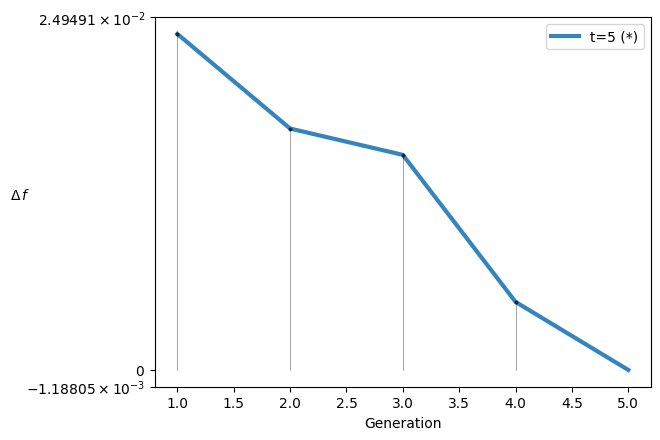

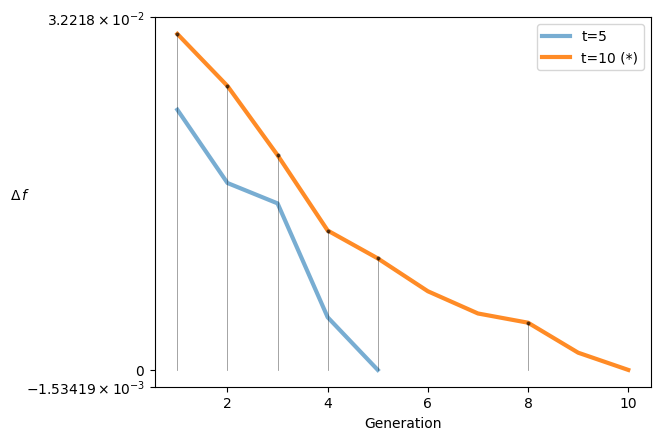

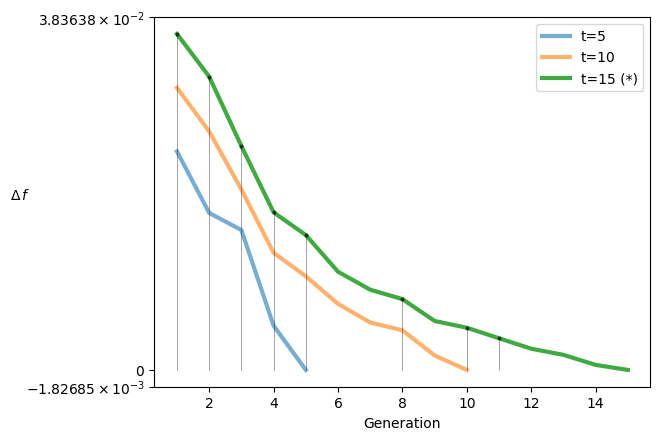

In [14]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=5,
                        n_plots=3,
                        key_press=False,
                        do_show=True)

for algorithm in result.history:
    running.update(algorithm)


### Results

In [15]:
root_dir = Path(__name__).parent.resolve()

def save_pareto_results(result, save_dir=root_dir / "pareto_results"):
    """Save Pareto front solutions using pandas pickle format"""
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True, parents=True)

    # Create DataFrame with all data
    df = pd.DataFrame({
        "accel_phase1": result.X[:, 0],
        "accel_phase2": result.X[:, 1],
        "travel_time_min": result.F[:, 0],
        "energy_consumption_kWh": result.F[:, 1],
    })

    # Save using pandas to_pickle (most efficient)
    df.to_pickle(save_dir / "pareto_data.pkl", protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Saved {len(result.F)} solutions to: {save_dir/'pareto_data.pkl'}")




save_pareto_results(result)

Saved 200 solutions to: /content/pareto_results/pareto_data.pkl
